In [1]:
import sys
sys.path.append('utils')
import os


In [2]:
import scanpy as sc

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2024-08-25 12:52:24.182939: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [129]:
gdf = gpd.read_file('../data/xenium/voronoi.geojson')

In [130]:
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]

In [132]:
gdf

,geometry,id
0,"POLYGON ((2211.48343 192.66895, 2226.34999 197...",ID_1
1,"POLYGON ((3134.63102 2905.93810, 3113.74772 29...",ID_2
2,"POLYGON ((3009.97357 3227.42716, 2825.38546 32...",ID_3
3,"POLYGON ((3069.17099 3396.28549, 2868.94138 36...",ID_4
4,"POLYGON ((3013.24541 3251.47770, 2980.02312 33...",ID_5
...,...,...
216318,"POLYGON ((27881.08890 21559.50413, 27909.21888...",ID_216319
216319,"POLYGON ((28922.30814 21240.85601, 28921.14949...",ID_216320
216320,"POLYGON ((27628.11104 21075.78659, 27651.26126...",ID_216321
216321,"POLYGON ((28855.34996 20799.55360, 28844.74516...",ID_216322


In [140]:
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')
adata.to_df()

feature_name,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,ZEB2,ZNF562,antisense_ADCY4,antisense_BCL2L15,antisense_LGI3,antisense_MYLIP,antisense_PROKR2,antisense_SCRIB,antisense_TRMU,antisense_ULK3
bin,,,,,,,,,,,,,,,,,,,,,
"(0, 1376)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1400)",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1402)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1415)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(0, 1425)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2201, 146)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(2201, 147)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(2201, 148)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
adata_df = adata.to_df()

In [142]:
adata_df.index

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1415)', '(0, 1425)',
       '(0, 1429)', '(0, 1431)', '(0, 1434)', '(0, 1437)', '(0, 1438)',
       ...
       '(2201, 133)', '(2201, 135)', '(2201, 137)', '(2201, 138)',
       '(2201, 140)', '(2201, 146)', '(2201, 147)', '(2201, 148)',
       '(2201, 153)', '(2201, 154)'],
      dtype='object', name='bin', length=3204769)

In [143]:
adata.obs

,sample,start_x,start_y,end_x,end_y,center_x,center_y,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
bin,,,,,,,,,,,,,,,
"(0, 1376)",sample1,5977.914968,19691.259132,5987.326733,19700.670896,5982.620851,19695.965014,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0
"(0, 1400)",sample1,5977.914968,19917.141485,5987.326733,19926.553249,5982.620851,19921.847367,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0
"(0, 1402)",sample1,5977.914968,19935.965014,5987.326733,19945.376779,5982.620851,19940.670896,2,1.098612,2,1.098612,100.0,100.0,100.0,100.0
"(0, 1415)",sample1,5977.914968,20058.317955,5987.326733,20067.729720,5982.620851,20063.023838,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0
"(0, 1425)",sample1,5977.914968,20152.435602,5987.326733,20161.847367,5982.620851,20157.141485,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2201, 146)",sample1,26693.209086,8114.788543,26702.620851,8124.200308,26697.914968,8119.494426,2,1.098612,2,1.098612,100.0,100.0,100.0,100.0
"(2201, 147)",sample1,26693.209086,8124.200308,26702.620851,8133.612073,26697.914968,8128.906190,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0
"(2201, 148)",sample1,26693.209086,8133.612073,26702.620851,8143.023838,26697.914968,8138.317955,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0


In [144]:
df_tissue_positions = adata_df
# Create an index in the dataframe to check joins
df_tissue_positions['index']=df_tissue_positions.index




In [145]:
df_tissue_positions.shape

(3204769, 542)

In [146]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(adata.obs['center_x'], adata.obs['center_y'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [147]:
gdf_coordinates

feature_name,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,antisense_ADCY4,antisense_BCL2L15,antisense_LGI3,antisense_MYLIP,antisense_PROKR2,antisense_SCRIB,antisense_TRMU,antisense_ULK3,index,geometry
bin,,,,,,,,,,,,,,,,,,,,,
"(0, 1376)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(0, 1376)",POINT (5982.621 19695.965)
"(0, 1400)",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(0, 1400)",POINT (5982.621 19921.847)
"(0, 1402)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(0, 1402)",POINT (5982.621 19940.671)
"(0, 1415)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(0, 1415)",POINT (5982.621 20063.024)
"(0, 1425)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(0, 1425)",POINT (5982.621 20157.141)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2201, 146)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(2201, 146)",POINT (26697.915 8119.494)
"(2201, 147)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(2201, 147)",POINT (26697.915 8128.906)
"(2201, 148)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(2201, 148)",POINT (26697.915 8138.318)


In [148]:
gdf

,geometry,id
0,"POLYGON ((2211.48343 192.66895, 2226.34999 197...",ID_1
1,"POLYGON ((3134.63102 2905.93810, 3113.74772 29...",ID_2
2,"POLYGON ((3009.97357 3227.42716, 2825.38546 32...",ID_3
3,"POLYGON ((3069.17099 3396.28549, 2868.94138 36...",ID_4
4,"POLYGON ((3013.24541 3251.47770, 2980.02312 33...",ID_5
...,...,...
216318,"POLYGON ((27881.08890 21559.50413, 27909.21888...",ID_216319
216319,"POLYGON ((28922.30814 21240.85601, 28921.14949...",ID_216320
216320,"POLYGON ((27628.11104 21075.78659, 27651.26126...",ID_216321
216321,"POLYGON ((28855.34996 20799.55360, 28844.74516...",ID_216322


In [149]:
gdf_coordinates.shape

(3204769, 543)

In [151]:
gdf.crs = None

In [152]:
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

In [44]:
result_spatial_join.shape

(3204769, 544)

In [153]:
result_spatial_join[result_spatial_join['index_right'].isna()]

,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,antisense_LGI3,antisense_MYLIP,antisense_PROKR2,antisense_SCRIB,antisense_TRMU,antisense_ULK3,index,geometry,index_right,id
bin,,,,,,,,,,,,,,,,,,,,,


In [154]:
# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()

In [155]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon']==True]


In [156]:
barcodes_in_one_polygon.shape

(3204769, 546)

In [157]:
barcodes_in_one_polygon

,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,ADIPOQ,AGR3,AHSP,AIF1,...,antisense_MYLIP,antisense_PROKR2,antisense_SCRIB,antisense_TRMU,antisense_ULK3,index,geometry,index_right,id,is_within_polygon
bin,,,,,,,,,,,,,,,,,,,,,
"(0, 1376)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"(0, 1376)",POINT (5982.621 19695.965),161787,ID_161788,True
"(0, 1400)",0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"(0, 1400)",POINT (5982.621 19921.847),157910,ID_157911,True
"(0, 1402)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"(0, 1402)",POINT (5982.621 19940.671),163633,ID_163634,True
"(0, 1415)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"(0, 1415)",POINT (5982.621 20063.024),158707,ID_158708,True
"(0, 1425)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"(0, 1425)",POINT (5982.621 20157.141),161206,ID_161207,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2201, 146)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"(2201, 146)",POINT (26697.915 8119.494),56092,ID_56093,True
"(2201, 147)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"(2201, 147)",POINT (26697.915 8128.906),56092,ID_56093,True
"(2201, 148)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,"(2201, 148)",POINT (26697.915 8138.318),56092,ID_56093,True


In [158]:
# Convert the tuples in barcodes_in_one_polygon['index'] to strings
barcodes_in_one_polygon['index'] = barcodes_in_one_polygon['index'].apply(lambda x: str(x))

# If you want to remove the 'bin' index name and set it as a regular column
barcodes_in_one_polygon.reset_index(inplace=True, drop=True)
print(barcodes_in_one_polygon['index'].head())
barcodes_in_one_polygon['index']

0    (0, 1376)
1    (0, 1400)
2    (0, 1402)
3    (0, 1415)
4    (0, 1425)
Name: index, dtype: object


0            (0, 1376)
1            (0, 1400)
2            (0, 1402)
3            (0, 1415)
4            (0, 1425)
              ...     
3204764    (2201, 146)
3204765    (2201, 147)
3204766    (2201, 148)
3204767    (2201, 153)
3204768    (2201, 154)
Name: index, Length: 3204769, dtype: object

In [109]:
#barcodes_in_one_polygon.set_index('index', inplace=True)
#barcodes_in_one_polygon['index'] = barcodes_in_one_polygon.index

In [159]:
barcodes_in_one_polygon['index']

0            (0, 1376)
1            (0, 1400)
2            (0, 1402)
3            (0, 1415)
4            (0, 1425)
              ...     
3204764    (2201, 146)
3204765    (2201, 147)
3204766    (2201, 148)
3204767    (2201, 153)
3204768    (2201, 154)
Name: index, Length: 3204769, dtype: object

In [160]:
adata.obs_names

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1415)', '(0, 1425)',
       '(0, 1429)', '(0, 1431)', '(0, 1434)', '(0, 1437)', '(0, 1438)',
       ...
       '(2201, 133)', '(2201, 135)', '(2201, 137)', '(2201, 138)',
       '(2201, 140)', '(2201, 146)', '(2201, 147)', '(2201, 148)',
       '(2201, 153)', '(2201, 154)'],
      dtype='object', name='bin', length=3204769)

In [161]:
barcodes_in_one_polygon.shape

(3204769, 546)

In [162]:
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

In [163]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])

In [164]:
filtered_adata = adata[filtered_obs_mask,:]

In [165]:
filtered_adata

View of AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [166]:
print(f"Length of filtered_adata.obs: {len(filtered_adata.obs)}")
print(f"Length of barcodes_in_one_polygon: {len(barcodes_in_one_polygon)}")

Length of filtered_adata.obs: 3204769
Length of barcodes_in_one_polygon: 3204769


In [168]:
print(filtered_adata.obs.index[:5])  # Print first few indices from filtered_adata.obs
print(barcodes_in_one_polygon['index'][:5])  # Print first few indices from barcodes_in_one_polygon

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1415)', '(0, 1425)'], dtype='object', name='bin')
bin
(0, 1376)    (0, 1376)
(0, 1400)    (0, 1400)
(0, 1402)    (0, 1402)
(0, 1415)    (0, 1415)
(0, 1425)    (0, 1425)
Name: index, dtype: object


In [169]:

# Add the results of the point spatial join to the Anndata object
filtered_adata.obs =  pd.merge(filtered_adata.obs, barcodes_in_one_polygon[['index','geometry', 'id', 'is_within_polygon','is_not_in_an_polygon_overlap']], left_index=True, right_index=True)


In [180]:
filtered_adata.obs

,sample,start_x,start_y,end_x,end_y,center_x,center_y,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,index,geometry,id,is_within_polygon,is_not_in_an_polygon_overlap
bin,,,,,,,,,,,,,,,,,,,,
"(0, 1376)",sample1,5977.914968,19691.259132,5987.326733,19700.670896,5982.620851,19695.965014,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0,"(0, 1376)",POINT (5982.621 19695.965),ID_161788,True,True
"(0, 1400)",sample1,5977.914968,19917.141485,5987.326733,19926.553249,5982.620851,19921.847367,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0,"(0, 1400)",POINT (5982.621 19921.847),ID_157911,True,True
"(0, 1402)",sample1,5977.914968,19935.965014,5987.326733,19945.376779,5982.620851,19940.670896,2,1.098612,2,1.098612,100.0,100.0,100.0,100.0,"(0, 1402)",POINT (5982.621 19940.671),ID_163634,True,True
"(0, 1415)",sample1,5977.914968,20058.317955,5987.326733,20067.729720,5982.620851,20063.023838,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0,"(0, 1415)",POINT (5982.621 20063.024),ID_158708,True,True
"(0, 1425)",sample1,5977.914968,20152.435602,5987.326733,20161.847367,5982.620851,20157.141485,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0,"(0, 1425)",POINT (5982.621 20157.141),ID_161207,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2201, 146)",sample1,26693.209086,8114.788543,26702.620851,8124.200308,26697.914968,8119.494426,2,1.098612,2,1.098612,100.0,100.0,100.0,100.0,"(2201, 146)",POINT (26697.915 8119.494),ID_56093,True,True
"(2201, 147)",sample1,26693.209086,8124.200308,26702.620851,8133.612073,26697.914968,8128.906190,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0,"(2201, 147)",POINT (26697.915 8128.906),ID_56093,True,True
"(2201, 148)",sample1,26693.209086,8133.612073,26702.620851,8143.023838,26697.914968,8138.317955,1,0.693147,1,0.693147,100.0,100.0,100.0,100.0,"(2201, 148)",POINT (26697.915 8138.318),ID_56093,True,True


In [181]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

In [182]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


In [183]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 152117 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [184]:
grouped_filtered_adata.write("../data/xenium/grouped_filtered_voronoi_adata.h5ad")

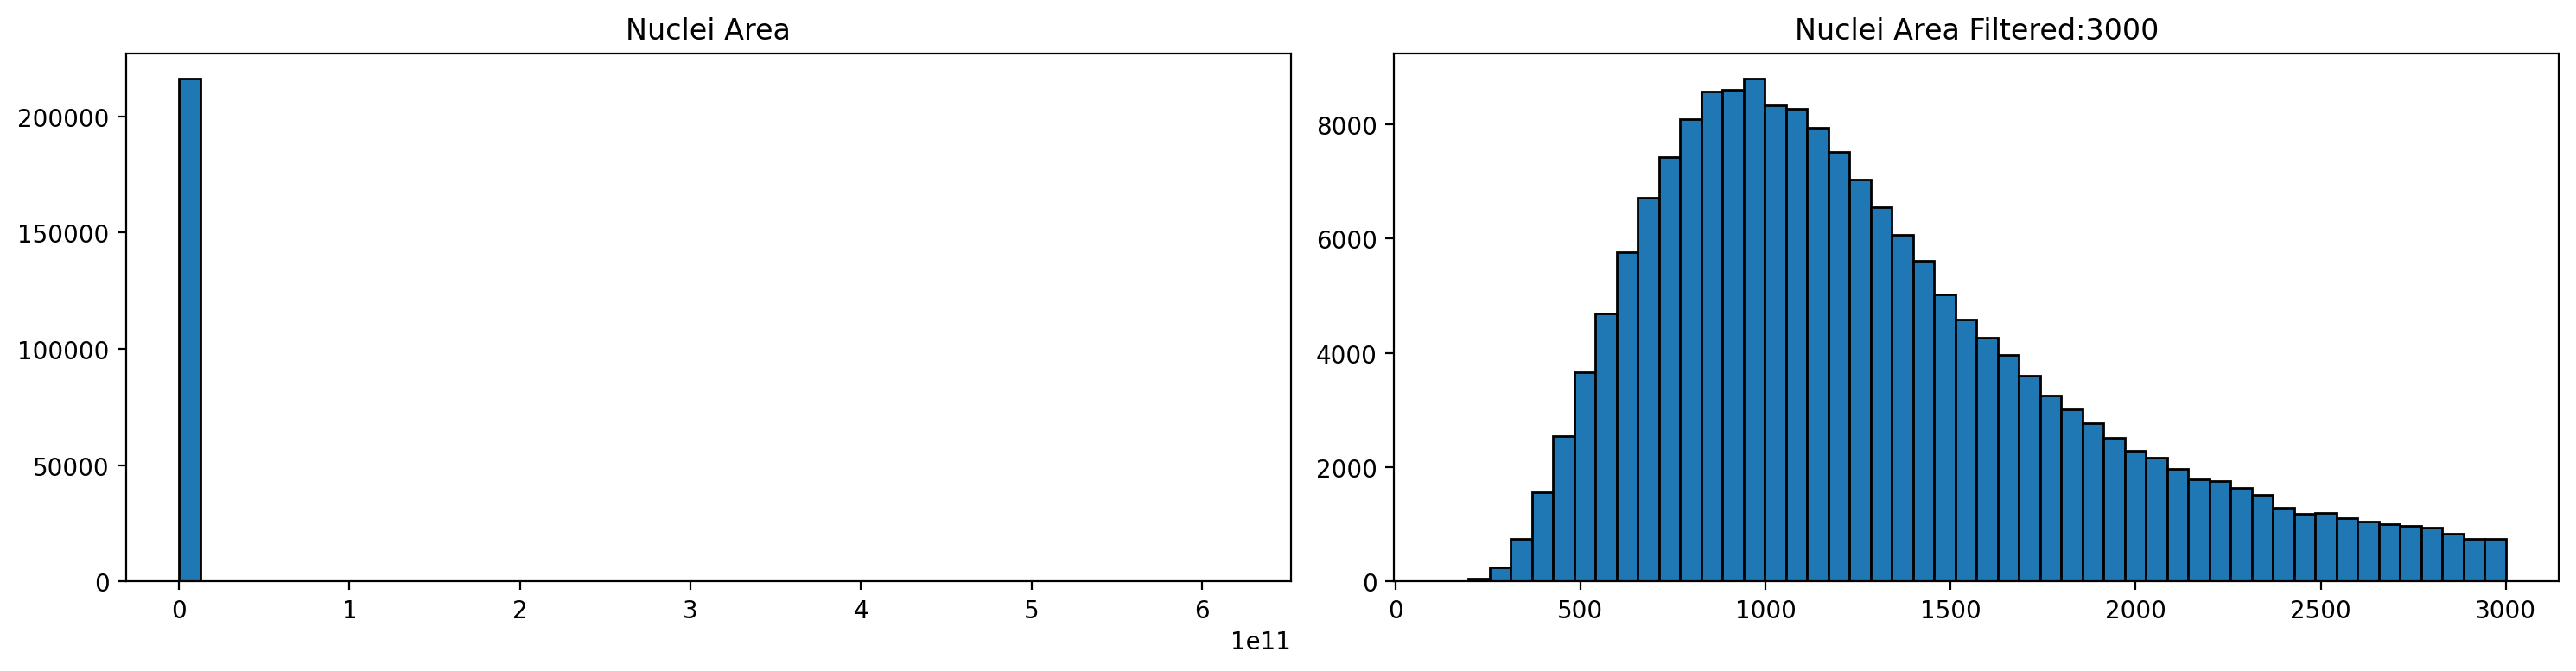

In [186]:
import importlib
import image_plot_utils

# Reload the module
importlib.reload(image_plot_utils)

# Now try importing the function again
from image_plot_utils import plot_nuclei_area

# Store the area of each nucleus in the GeoDataframe
gdf['area'] = gdf['geometry'].area

# Calculate quality control metrics for the original AnnData object
sc.pp.calculate_qc_metrics(grouped_filtered_adata, inplace=True)

# Plot the nuclei area distribution before and after filtering
plot_nuclei_area(gdf=gdf,area_cut_off=3000)

In [187]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
mask_area = grouped_filtered_adata.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata[mask_area, :]

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


_qc.py (141): Trying to modify attribute `.obs` of view, initializing view as actual.


In [188]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
4284375964.py (19): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


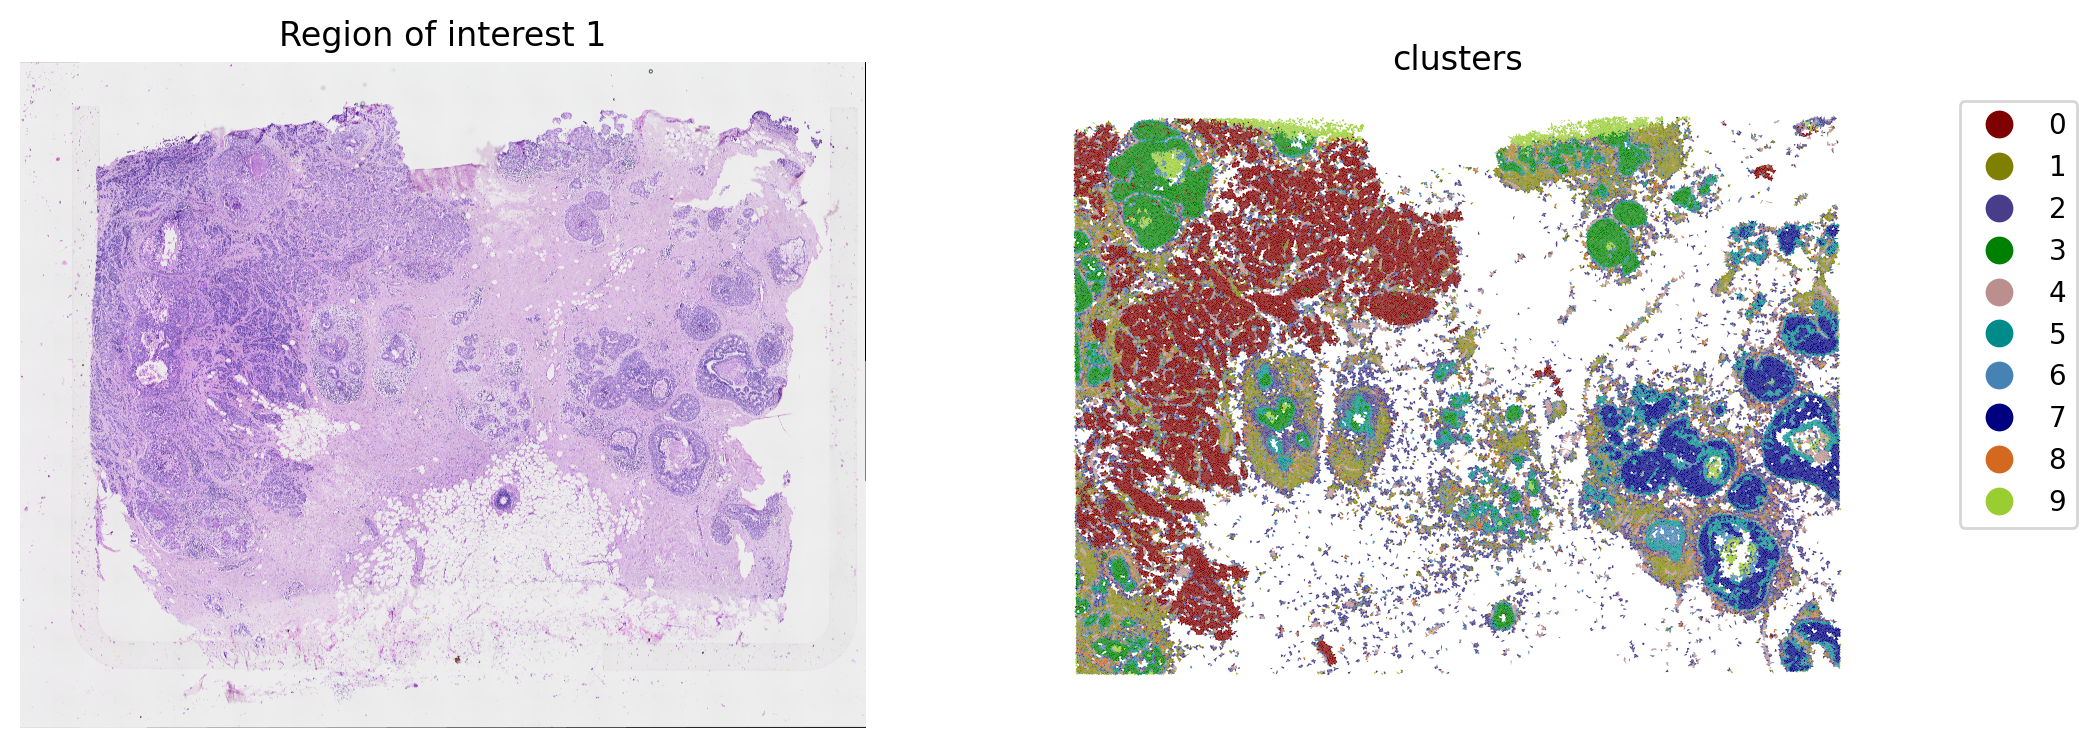

In [189]:
from image_plot_utils import plot_clusters_and_save_image
importlib.reload(image_plot_utils)
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")